In [1]:
import dask
import pystac_client
import planetary_computer
import leafmap
import geogif
import stackstac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from avgNdwi import main
from scipy.stats import gaussian_kde
import utils as ut

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 13.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34213,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 13.65 GiB
Comm: tcp://127.0.0.1:37017,Total threads: 2
Dashboard: http://127.0.0.1:36943/status,Memory: 3.41 GiB
Nanny: tcp://127.0.0.1:37547,


In [3]:
bbox = (-71.882047, 42.0215975, -71.72, 42.299624)
start = '2023-01-01'
end = '2024-01-01'
year = 2023

In [58]:
def average(dataArray):
    avgArray = dataArray.mean(dim=["time"], skipna=True)
    return avgArray


def get_bands(start, end, bbox):
    """
    This function takes in a spatial and temporal timeframe,
        and finds appropriate landast data from microsoft's planetary computer website.
    It then calculates ndvi as a new column within the fetched data, 
        and returns the full array.
    Inputs: 
    start = datetime object, representing the start of the time period of interest
    end = datetime object, representing the end of the time period of interest
    bbox = spatial bounding box
    Outputs:
    xarray.DataArray with ndvi data
    """
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,)
    search = catalog.search(
        collections = ['landsat-c2-l2'],
        bbox = bbox,
        query={
        "eo:cloud_cover": {"lt": 20},
        "platform": {"in": ["landsat-8", "landsat-9"]}
    },
        datetime = start + "/" + end
    )
    items = search.get_all_items()
    #items = list(search.get_items())
    # for item in items[:15]:  # Inspect the first 5 items
    #     print(item.properties.get("platform"))
    # print(len(items))
    # # print(items[2])
    # for item in items:
    #     print(item.assets.keys())
    #     break

    stack = stackstac.stack(items, assets=["nir08", "red", "lwir11", "qa_pixel"], epsg = 4326, bounds_latlon=bbox)

    mask_bitfields = [1, 2, 3, 4, 7]
    bitmask = 0
    for field in mask_bitfields:
        bitmask |= 1 << field
    
    bin(bitmask)
    
    qa = stack.sel(band="qa_pixel").astype("uint16")
    mask = qa & bitmask
    
    stackNoClouds = stack.where(mask == 0)
    
    B3 = stackNoClouds.sel(band = "red")
    B4 = stackNoClouds.sel(band = "nir08")
    LST = stackNoClouds.sel(band = "lwir11")
    B3 = B3.where(B3 > 0, np.nan)
    B4 = B4.where(B4 > 0, np.nan)
    ndvi = (B4 - B3) / (B4 + B3)

    LST = LST - 273.15

    return ndvi, LST


# https://docs.xarray.dev/en/stable/examples/monthly-means.html
def season_mean_dict(ds, calendar="standard"):
    # from xarray documentation example
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    weighted_average = (ds * weights).groupby("time.season").sum(dim="time")

    
    # original code
    ordered_seasons = ['winter', 'summer', 'spring', 'fall']
    d = {}
    count = 0
    for season in weighted_average:
        d[ordered_seasons[count]] = season
        count += 1
    return d

def scatter_ndvi_lst(ndvi, lst):
    plt.rcParams['figure.figsize'] = (12,8)
    plt.figure(figsize = (5, 5))
    plt.scatter(x=ndvi, y=lst)
    plt.xlabel("NDVI")
    plt.ylabel("LST")
    plt.ylim(0,50)
    plt.xlim(-5,5)
    plt.show()

In [59]:
ndvi, lst = get_bands(start, end, bbox)

38


In [50]:
avgNdvi = season_mean_dict(ndvi, calendar="standard")
avgLST = season_mean_dict(lst, calendar="standard")

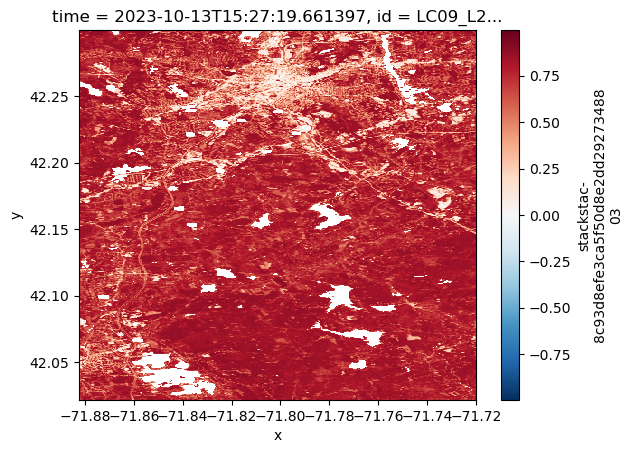

In [53]:
ndvi[15].plot()

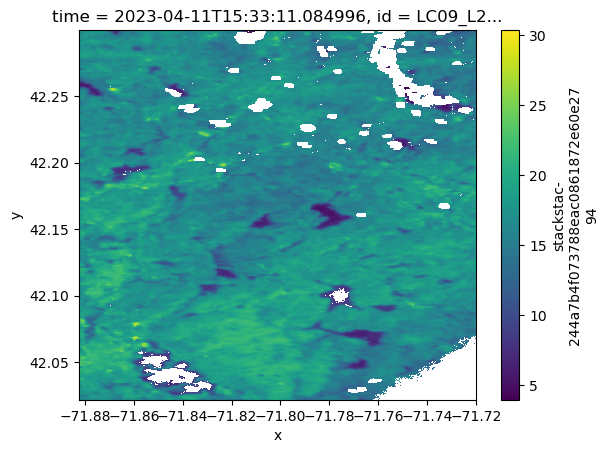

In [43]:
lst[4].plot()

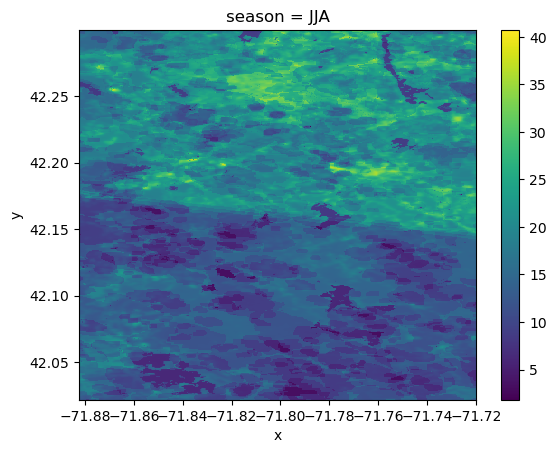

In [44]:
avgLST["summer"].plot()

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,)
search = catalog.search(
    collections = ['landsat-c2-l2'],
    bbox = bbox,
    query=["eo:cloud_cover<10"],
    datetime = start[0] + "/" + end[0]
)
items = search.get_all_items()
len(items)
print(items[2])
for item in items:
    print(item.assets.keys())
    break

<Item id=LC08_L2SP_013031_20231113_02_T1>
dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


In [7]:
stack = stackstac.stack(items, assets=["nir08", "red", "lwir", "qa_pixel"], epsg = 4326, bounds_latlon=bbox)
#stack = stackstac.stack(items, assets=["nir08", "red", "lwir"], epsg = 4326, bounds_latlon=bbox)

In [8]:
mask_bitfields = [1, 2, 3, 4, 7]
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

qa = stack.sel(band="qa_pixel").astype("uint16")
mask = qa & bitmask

stackNoClouds = stack.where(mask == 0)

In [9]:
B3 = stackNoClouds.sel(band = "red")
B4 = stackNoClouds.sel(band = "nir08")
LST = stackNoClouds.sel(band = "lwir")
B3 = B3.where(B3 > 0, np.nan)
B4 = B4.where(B4 > 0, np.nan)
ndvi = (B4 - B3) / (B4 + B3)

# red_min = B3.min().compute().item()  # Get the minimum NDVI value
# red_max = B3.max().compute().item()  # Get the maximum NDVI value

# swir16_min = B4.min().compute().item()  # Get the minimum NDVI value
# swir16_max = B4.max().compute().item()  # Get the maximum NDVI value

# ndvi_min = ndvi.min().compute().item()  # Get the minimum NDVI value
# ndvi_max = ndvi.max().compute().item()  # Get the maximum NDVI value

# LST_min = LST.min().compute().item()  # Get the minimum NDVI value
# LST_max = LST.max().compute().item()  # Get the maximum NDVI value

# print(f"NDVI range: {ndvi_min:.4f} to {ndvi_max:.4f}")
# print(f"Red range: {red_min:.4f} to {red_max:.4f}")
# print(f"Swir16 range: {swir16_min:.4f} to {swir16_max:.4f}")
# print(f"Temp range: {LST_min:.4f} to {LST_max:.4f}")

springNdvi = ndvi.sel(time=slice(f"{year}-03-21", f"{year}-06-21"))
summerNdvi = ndvi.sel(time=slice(f"{year}-06-21", f"{year}-09-23"))
fallNdvi = ndvi.sel(time=slice(f"{year}-09-23", f"{year}-12-22"))
winterNdvi1 = ndvi.sel(time=slice(f"{year}-12-22", f"{year}-12-31"))
winterNdvi2 = ndvi.sel(time=slice(f"{year}-01-01", f"{year}-03-20"))

LST = LST - 273.15

springLST = LST.sel(time=slice(f"{year}-03-21", f"{year}-06-21"))
summerLST = LST.sel(time=slice(f"{year}-06-21", f"{year}-09-23"))
fallLST = LST.sel(time=slice(f"{year}-09-23", f"{year}-12-22"))
winterLST1 = LST.sel(time=slice(f"{year}-12-22", f"{year}-12-31"))
winterLST2 = LST.sel(time=slice(f"{year}-01-01", f"{year}-03-20"))

avgSummerNdvi = summerNdvi.mean(dim=["time"], skipna=True)
avgSpringNdvi = springNdvi.mean(dim=["time"], skipna=True)
avgFallNdvi = fallNdvi.mean(dim=["time"], skipna=True)

avgFallLST = fallLST.mean(dim=["time"], skipna=True)
avgSpringLST = springLST.mean(dim=["time"], skipna=True)
avgSummerLST = summerLST.mean(dim=["time"], skipna=True)

# print(len(ndvi))
# print(len(springNdvi))
# print(len(fallNdvi))
# print(len(fallLST))
# print(len(winterNdvi1))
# print(len(winterNdvi2))
# print(len(summerNdvi))
# print((avgFallLST))
# print((avgSummerLST))
# print((avgFallNdvi))
# print((avgSummerNdvi))
# avgSummerNdvi.head()
# print(B3)

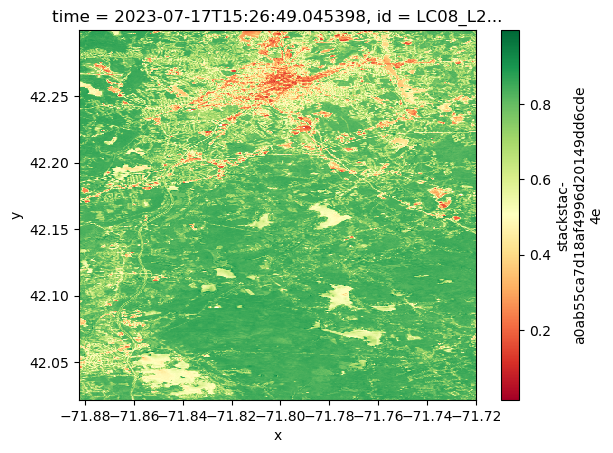

In [10]:
summerNdvi[2].plot(cmap='RdYlGn')

/opt/conda/envs/ndvi-lst/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/opt/conda/envs/ndvi-lst/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/opt/conda/envs/ndvi-lst/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


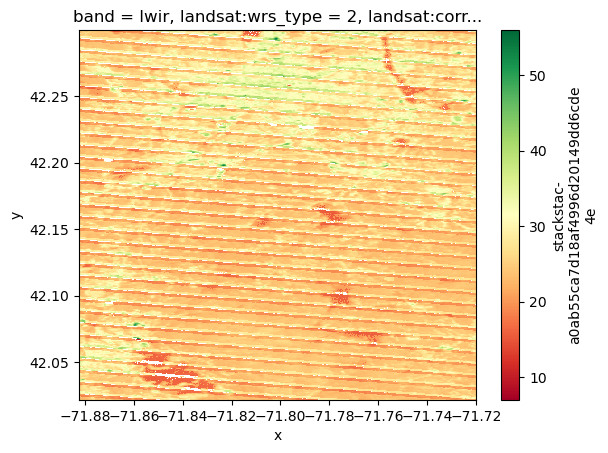

In [11]:
avgSpringLST.plot(cmap='RdYlGn')

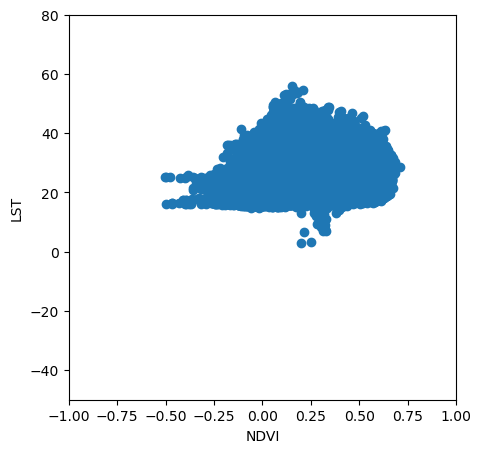

In [59]:
plt.rcParams['figure.figsize'] = (12,8)
plt.figure(figsize = (5, 5))
plt.scatter(x=avgSpringNdvi, y=avgSpringLST)
plt.xlabel("NDVI")
plt.ylabel("LST")
plt.ylim(-50,80)
plt.xlim(-1,1)
plt.show()

In [ ]:
def removeExtraneous(ndvi):
    reducedNdvi = ndvi.where((ndvi >= -1) & (ndvi <= 1))
    return reducedNdvi

In [ ]:
reducedSpringNdvi = removeExtraneous(springAvgNdvi)
reducedSummerNdvi = removeExtraneous(summerAvgNdvi)
print(len(reducedSpringNdvi))
print(len(summerNdvi))

In [ ]:
def average(dataArray):
    avgArray = dataArray.mean(dim=["time"], skipna=True)
    return avgArray

In [ ]:
springAvgNdvi = average(springNdvi)
summerAvgNdvi = average(summerNdvi)

In [ ]:
# avgNdvi.plot()

# normalized_avgNdvi = springNdvi
# normalized_avgNdvi = normalized_avgNdvi.where((normalized_avgNdvi >= -1) & (normalized_avgNdvi <= 1))
# avgNdvi = normalized_avgNdvi
#springAvgNdvi.plot(cmap='RdYlGn')
#avgNdvi.plot(cmap='RdYlGn')

In [ ]:
avgSummerNdvi.plot(cmap='RdYlGn')

In [ ]:
avgLst_values = avgLst.values 
avgNdvi_values = avgNdvi.values 

# Remove NaN values from both avgLst and avgNdvi
valid_mask = ~np.isnan(avgLst_values) & ~np.isnan(avgNdvi_values)

# Apply the mask to both arrays
avgLst_valid = avgLst_values[valid_mask]
avgNdvi_valid = avgNdvi_values[valid_mask]

In [8]:
hist, xedges, yedges = np.histogram2d(avgNdvi_valid.flatten(), avgLst_valid.flatten(), bins=1000)

plt.figure(figsize=(5,5))
plt.imshow(
    hist.T, 
    origin='lower', 
    aspect='auto', 
    extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
    cmap='viridis',
    vmax=10
)
plt.colorbar(label='Density')
plt.xlabel("NDVI")
plt.ylabel("LST")
plt.ylim(15,50)
plt.xlim(0,1)
plt.show()

NameError: name 'avgNdvi_valid' is not defined

In [63]:
def createDensity(avgNdvi, avgLst):
    # Convert to numpy arrays
    avgLst = np.asarray(avgLst.values)
    avgNdvi = np.asarray(avgNdvi.values)

    # Create a valid mask
    valid_mask = ~np.isnan(avgLst) & ~np.isnan(avgNdvi)

    # Apply mask and flatten
    avgLst = avgLst[valid_mask].flatten()
    avgNdvi = avgNdvi[valid_mask].flatten()

    # Create histogram
    hist, xedges, yedges = np.histogram2d(avgNdvi, avgLst, bins=1000)

    # Plotting the density
    plt.figure(figsize=(5,5))
    plt.imshow(
        hist.T, 
        origin='lower', 
        aspect='auto', 
        extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
        cmap='viridis',
        vmax=10
    )
    plt.colorbar(label='Density')
    plt.xlabel("NDVI")
    plt.ylabel("LST")
    plt.xlim(-1,1)
    plt.show()

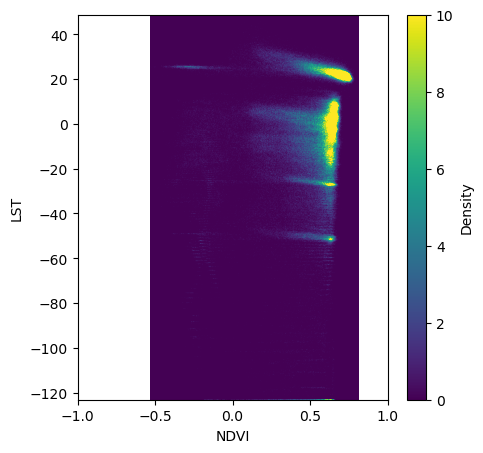

In [64]:
createDensity(avgSummerNdvi, avgSummerLST)

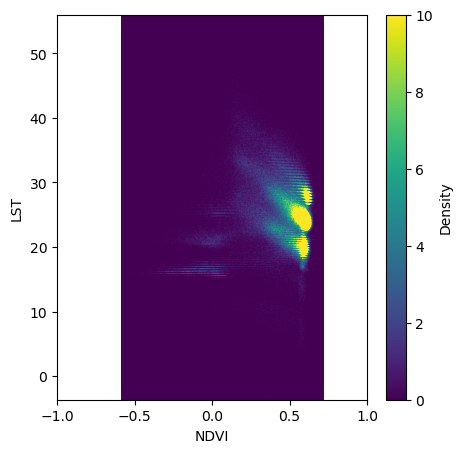

In [65]:
createDensity(avgSpringNdvi, avgSpringLST)

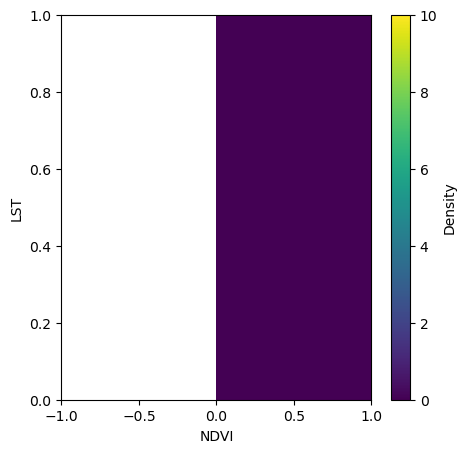

In [66]:
createDensity(avgFallNdvi, avgFallLST)